<a href="https://colab.research.google.com/github/gauravdaga06/Machine-Learning/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

#Tensorflow Import Keras
from tensorflow import keras
keras.__version__ >="2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#for visualization 
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

*Importing Dataset*

In [2]:
#! pip install -q kaggle

In [3]:
 #from google.colab import files
 #files.upload()

In [4]:
#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

In [5]:
#! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#! kaggle datasets download -d jihyeseo/online-retail-data-set-from-uci-ml-repo

In [7]:

#! unzip online-retail-data-set-from-uci-ml-repo -d online_retail

In [8]:
retail_data = pd.read_excel('online_retail/Online Retail.xlsx')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
retail_data.shape

(541909, 8)

**Data Cleaning**

In [10]:
country_cluster_data  = retail_data[['Country','CustomerID']].drop_duplicates()
country_cluster_data.head()

,Country,CustomerID
0,United Kingdom,17850.0
9,United Kingdom,13047.0
26,France,12583.0
46,United Kingdom,13748.0
65,United Kingdom,15100.0


In [11]:
#getting the count of each country
country_cluster_data.groupby(['Country'])['CustomerID'].agg('count').reset_index().sort_values('CustomerID',ascending =False)


,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [12]:
#we have maximum customers from United Kingdom So We keep the data Of UK only
#shortly we are targeting UK population
retail_data =retail_data.query("Country== 'United Kingdom'").reset_index(drop = True)
retail_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [13]:
retail_data.shape

(495478, 8)

In [14]:
#checking for missing value
retail_data.isnull().sum(axis = 0)   #from the output we conclude that there are 2 columns with null values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [15]:
#Removing the missing values from customerid column ,Ignoring the missing values from description
retail_data = retail_data[pd.notnull(retail_data['CustomerID'])]

#checking for negative value in Quantity column because quantity cannot be negative
retail_data['Quantity'].min()

-80995

In [16]:
#checking for negative value in Unit Price column
retail_data['UnitPrice'].min()  #output gives the minimum value in unitprice column which means that there is no -ve value in this column

0.0

In [17]:
#filtering out the records with negative value in Quality column
retail_data = retail_data[(retail_data['Quantity']>0)]

In [18]:
retail_data['Quantity'].min()         #this means no negative data now

1

In [19]:
retail_data.shape

(354345, 8)

In [20]:
retail_data['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
495473   2011-12-09 12:31:00
495474   2011-12-09 12:49:00
495475   2011-12-09 12:49:00
495476   2011-12-09 12:49:00
495477   2011-12-09 12:49:00
Name: InvoiceDate, Length: 354345, dtype: datetime64[ns]

In [21]:
#converting the date string to datetime format to perform date related operations on it
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

In [22]:
retail_data['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
495473   2011-12-09 12:31:00
495474   2011-12-09 12:49:00
495475   2011-12-09 12:49:00
495476   2011-12-09 12:49:00
495477   2011-12-09 12:49:00
Name: InvoiceDate, Length: 354345, dtype: datetime64[ns]

In [23]:
retail_data['TotalAmount'] = retail_data['Quantity']*retail_data['UnitPrice']

In [24]:
retail_data.shape

(354345, 9)

In [25]:
retail_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


**RFM Modeling**

*Recency — How recently did the customer purchase?*

*Frequency — How often do they purchase?*

*Monetary Value — How much do they spend?* 

In [26]:
import datetime as dt

In [27]:
#setting latest date to 10-12-2011 because our Invice date is 09-12-2011 to calculate the number of days ffron recent purchesepurchase 
latest_date  = dt.datetime(2011,12,10)

#RFM modeling score for each customers 
rfm_score = retail_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latest_date - x.max()).days , 'InvoiceNo': lambda x : (len(x)) , 'TotalAmount' : lambda x : (x.sum())})

#convert invoice date into int
rfm_score['InvoiceDate'] = rfm_score['InvoiceDate'].astype(int)

#renaming the rfm_score
rfm_score.rename(columns  = {'InvoiceDate' : 'Recency',
                             'InvoiceNo' : 'Frequency',
                             'TotalAmount' : 'MonetaryValue'},inplace = True)
    


In [28]:
rfm_score.reset_index().head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


from above table we conclude that from the first row the customer with customerid 12346.0 ha bought product 325 days ago approx 11 months and he is our new  customer and might have bought due to some discount

In [29]:
rfm_score.describe()

,Recency,Frequency,MonetaryValue
count,3921.000000,3921.000000,3921.000000
mean,91.722265,90.371079,1863.910113
std,99.528532,217.796155,7481.922217
min,0.000000,1.000000,0.000000
25%,17.000000,17.000000,300.040000
50%,50.000000,41.000000,651.820000
75%,142.000000,99.000000,1575.890000
max,373.000000,7847.000000,259657.300000


In [30]:
rfm_score.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


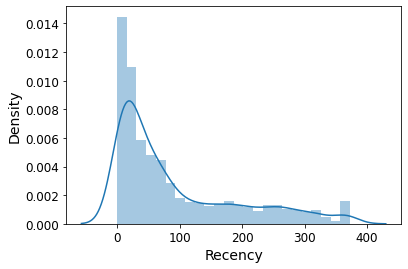

In [31]:
#Recency Distribution Plot using Seaborn

x = rfm_score['Recency']
ax = sns.distplot(x)

In [32]:
 rfm_score.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


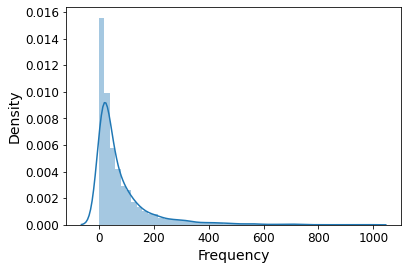

In [33]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x = rfm_score.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [34]:
rfm_score.MonetaryValue.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: MonetaryValue, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


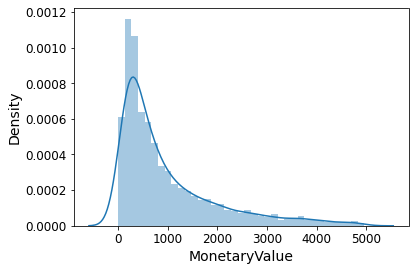

In [35]:
sns.distplot(rfm_score.query('MonetaryValue<5000')['MonetaryValue'])

In [36]:
#splitting into four segments using quantiles
#a quantile determines how many values in a distribution are above or below a certain limit
quantiles = rfm_score.quantile(q = [0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [37]:
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'MonetaryValue': {0.25: 300.03999999999996,
  0.5: 651.8199999999999,
  0.75: 1575.89},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

In [47]:
#function to create R,F and M segments
def Rscoring(x,p,d):          #less the value of Recency Rscoring better will be the Customer
  if x<=d[p][0.25]:
    return 1
  elif x <= d[p][0.5]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4
  
def FnMscoring(x,p,d):           #more the value Of Frequency & monetering FnMscoring good is the customer
  if x <= d[p][0.25]:
    return 4
  if x <= d[p][0.5]:
    return 3
  if x <= d[p][0.75]:
    return 2  
  else:
    return 1

In [49]:
#Calculating the R,F,&M values column
rfm_score['R'] = rfm_score['Recency'].apply(Rscoring , args =('Recency',quantiles) )
rfm_score['F'] = rfm_score['Frequency'].apply(FnMscoring , args =('Frequency',quantiles) )
rfm_score['M'] = rfm_score['MonetaryValue'].apply(FnMscoring , args =('MonetaryValue',quantiles) )

In [50]:
rfm_score.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [52]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_score['RFMGroup'] = rfm_score.R.map(str) + rfm_score.F.map(str) + rfm_score.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_score['RFMScore'] = rfm_score[['R', 'F', 'M']].sum(axis = 1)
rfm_score.head()

#lower the value of RFMScore more good is the customer

,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


In [53]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm_score.RFMScore, q = 4, labels = Loyalty_Level)
rfm_score['RFM_Loyalty_Level'] = Score_cuts.values
rfm_score.reset_index().head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [55]:
#Validate the data for RFMGroup = 111
rfm_score[rfm_score['RFMGroup']=='111'].sort_values('MonetaryValue', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,Platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,Platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,Platinum


In [62]:
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = rfm_score.query("MonetaryValue < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.5
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.2
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [63]:
#Frequency Vs Monetary
graph = rfm_score.query("MonetaryValue < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['MonetaryValue'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['MonetaryValue'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['MonetaryValue'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['MonetaryValue'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "MonetaryValue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [64]:
#Recency Vs Monetary
graph = rfm_score.query("MonetaryValue < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['MonetaryValue'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['MonetaryValue'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['MonetaryValue'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['MonetaryValue'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "MonetaryValue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [67]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_score['Recency'] = [handle_neg_n_zero(x) for x in rfm_score.Recency]
rfm_score['MonetaryValue'] = [handle_neg_n_zero(x) for x in rfm_score.MonetaryValue]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_score[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



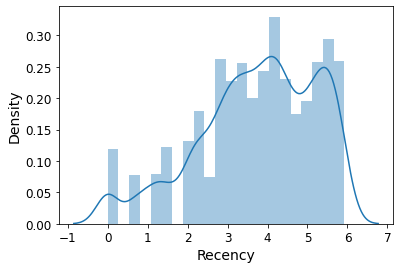

In [68]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



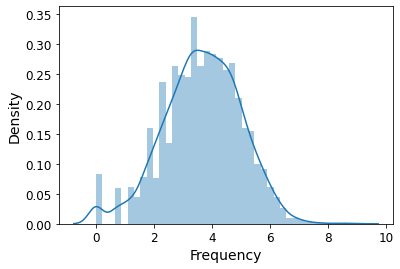

In [69]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



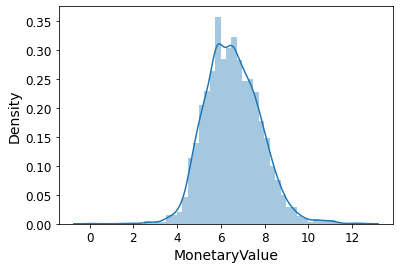

In [71]:

#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('MonetaryValue < 10000')['MonetaryValue']
ax = sns.distplot(Monetary_Plot)

In [73]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_score.index, columns = Log_Tfd_Data.columns)

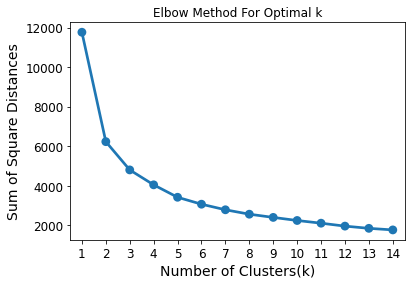

In [74]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [77]:

#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
rfm_score['Cluster'] = KMean_clust.labels_
rfm_score.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2


<Figure size 504x504 with 0 Axes>

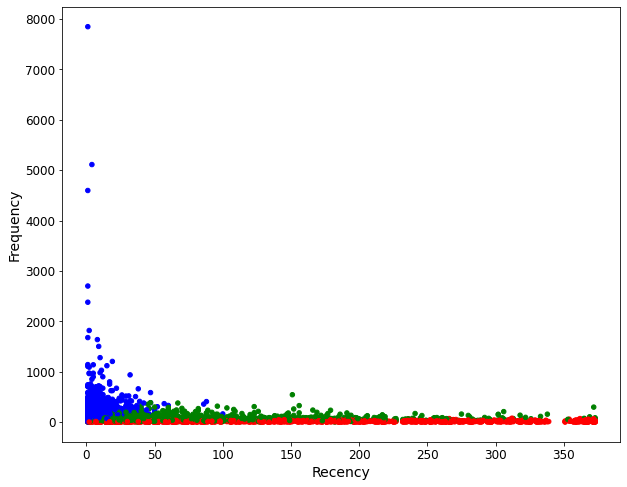

In [79]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
rfm_score['Color'] = rfm_score['Cluster'].map(lambda p: Colors[p])
ax = rfm_score.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = rfm_score['Color']
)

In [81]:
rfm_score

,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1,green
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,blue
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,blue
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,blue
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,blue
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,4,4,4,444,12,Bronze,0,red
18281.0,180,7,80.82,4,4,4,444,12,Bronze,0,red
18282.0,7,12,178.05,1,4,4,144,9,Silver,0,red


In [82]:
rfm_score.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1,green
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,blue
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,blue
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,blue
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,blue
